# Course Notes
Use this workspace to take notes, store code snippets, or build your own interactive cheatsheet! The datasets used in this course are available in the `datasets` folder.


In [278]:
# Import any packages you want to use here
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, precision_recall_fscore_support, roc_auc_score, roc_curve, accuracy_score, confusion_matrix
import numpy as np

## Explore the credit data

Expected loss is a simple calculation of the following three components:
- The probability of default, which is the likelihood someone will default on a loan. 
- The exposure at default which is the amount outstanding at the time of default. 
- And the loss given default which is the ratio of the exposure against any recovery from the loss. 

In [279]:
cr_loan = pd.read_csv('datasets/cr_loan2.csv')

In [280]:
# Check the first five rows of the data
cr_loan.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,$123.00,PERSONAL,D,35000,$16.02,1,$0.59,Y,3
1,21,9600,OWN,$5.00,EDUCATION,B,1000,$11.14,0,$0.10,N,2
2,25,9600,MORTGAGE,$1.00,MEDICAL,C,5500,$12.87,1,$0.57,N,3
3,23,65500,RENT,$4.00,MEDICAL,C,35000,$15.23,1,$0.53,N,2
4,24,54400,RENT,$8.00,MEDICAL,C,35000,$14.27,1,$0.55,Y,4


### Exploring with visuals

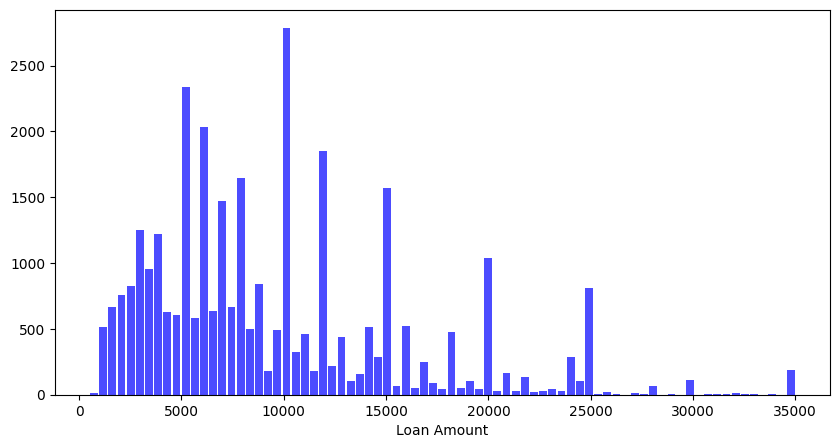

In [281]:
# Look at the distribution of loan amounts with a histogram
plt.figure(figsize=(10,5))
n, bins, patches = plt.hist(x=cr_loan['loan_amnt'], bins='auto', color='blue',alpha=0.7, rwidth=0.85)
plt.xlabel("Loan Amount")
plt.show()

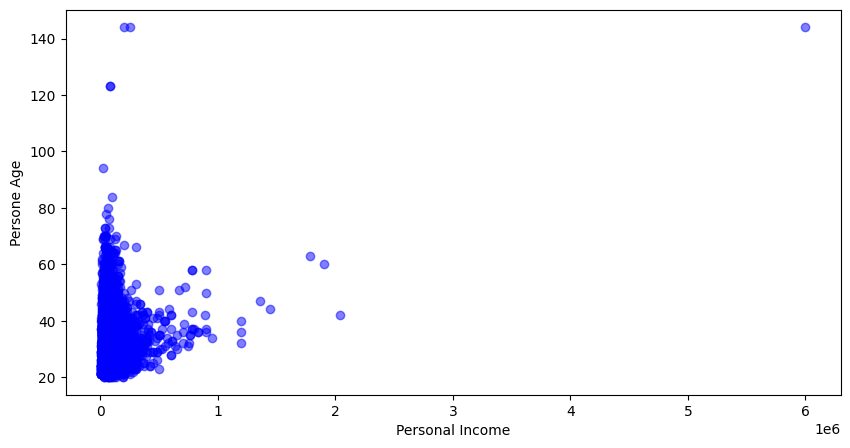

In [282]:
# Plot a scatter plot of income against age
plt.figure(figsize=(10,5))
plt.scatter(cr_loan['person_income'], cr_loan['person_age'], c='blue', alpha=0.5)
plt.xlabel('Personal Income')
plt.ylabel('Persone Age')
plt.show()

We can  see a positive correlation with age and income, which could mean these older recipients are further along in their career and therefore earn higher salaries. There also appears to be an outlier in the data.

### Exploring with cross tables

In [283]:
# Create a cross table of the loan intent and loan status
pd.crosstab(cr_loan['loan_intent'], cr_loan['loan_status'], margins = True)

loan_status,0,1,All
loan_intent,,,
DEBTCONSOLIDATION,3722,1490,5212
EDUCATION,5342,1111,6453
HOMEIMPROVEMENT,2664,941,3605
MEDICAL,4450,1621,6071
PERSONAL,4423,1098,5521
VENTURE,4872,847,5719
All,25473,7108,32581


In [284]:
# Create a cross table of home ownership, loan status, and grade
pd.crosstab(cr_loan['person_home_ownership'],[cr_loan['loan_status'],cr_loan['loan_grade']])

loan_status               0                        ...    1                   
loan_grade                A     B     C    D    E  ...    C     D    E   F   G
person_home_ownership                              ...                        
MORTGAGE               5219  3729  1934  658  178  ...  321   553  161  61  31
OTHER                    23    29    11    9    2  ...    6    11    6   2   0
OWN                     860   770   464  264   26  ...   31    18   31   8   5
RENT                   3602  4222  2710  554  137  ...  981  1559  423  99  27

[4 rows x 14 columns]

In [285]:
# Create a cross table of home ownership, loan status, and average percent income
pd.crosstab(cr_loan['person_home_ownership'], cr_loan['loan_status'],
              values=cr_loan['loan_percent_income'], aggfunc='mean')

loan_status,0,1
person_home_ownership,,
MORTGAGE,$0.15,$0.18
OTHER,$0.14,$0.30
OWN,$0.18,$0.30
RENT,$0.14,$0.26


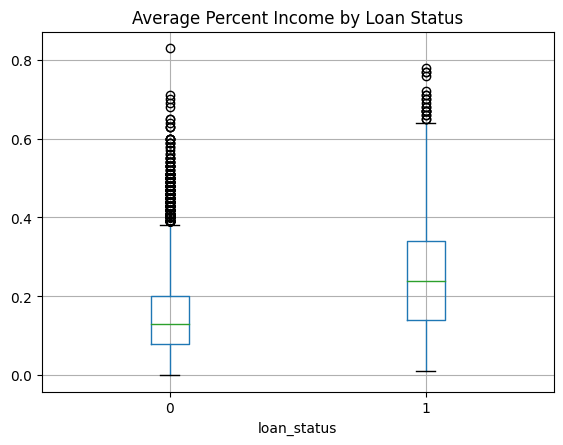

In [286]:
# Create a box plot of percentage income by loan status
cr_loan.boxplot(column = ['loan_percent_income'], by = 'loan_status')
plt.title('Average Percent Income by Loan Status')
plt.suptitle('')
plt.show()

The average percentage of income for defaults is higher. This could indicate those recipients have a debt-to-income ratio that's already too high.

## Outliers

### Finding outliers with cross tables

In [287]:
# Create the cross table for loan status, home ownership, and the max employment length
pd.crosstab(cr_loan['loan_status'],cr_loan['person_home_ownership'],
                  values=cr_loan['person_emp_length'], aggfunc='max')

person_home_ownership,MORTGAGE,OTHER,OWN,RENT
loan_status,,,,
0,$123.00,$24.00,$31.00,$41.00
1,$34.00,$11.00,$17.00,$123.00


In [288]:
# Create an array of indices where employment length is greater than 60
indices = cr_loan[cr_loan['person_emp_length'] > 60].index

# Drop the records from the data based on the indices and create a new dataframe
cr_loan_new = cr_loan.drop(indices)

In [289]:
# Create the cross table from earlier and include minimum employment length
pd.crosstab(cr_loan_new['loan_status'],cr_loan_new['person_home_ownership'],
            values=cr_loan_new['person_emp_length'], aggfunc=['min','max'])

min                        max                     
person_home_ownership MORTGAGE OTHER   OWN  RENT MORTGAGE  OTHER    OWN   RENT
loan_status                                                                   
0                        $0.00 $0.00 $0.00 $0.00   $38.00 $24.00 $31.00 $41.00
1                        $0.00 $0.00 $0.00 $0.00   $34.00 $11.00 $17.00 $27.00

### Visualizing credit outliers

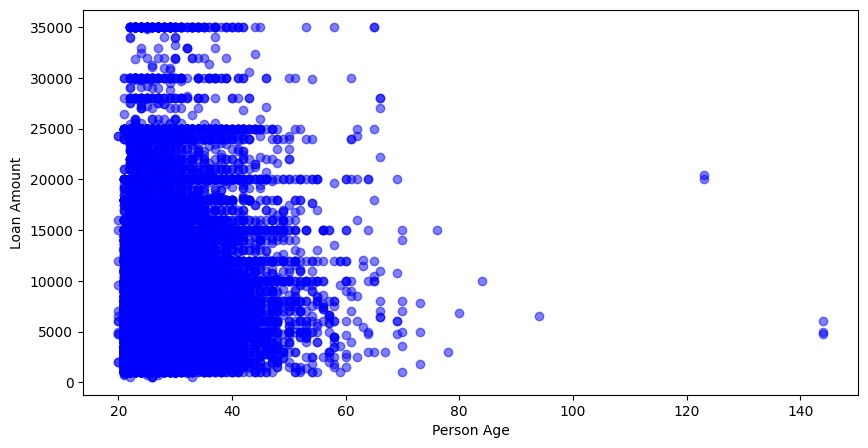

In [290]:
# Create the scatter plot for age and amount
plt.figure(figsize=(10,5))
plt.scatter(cr_loan['person_age'], cr_loan['loan_amnt'], c='blue', alpha=0.5)
plt.xlabel("Person Age")
plt.ylabel("Loan Amount")
plt.show()

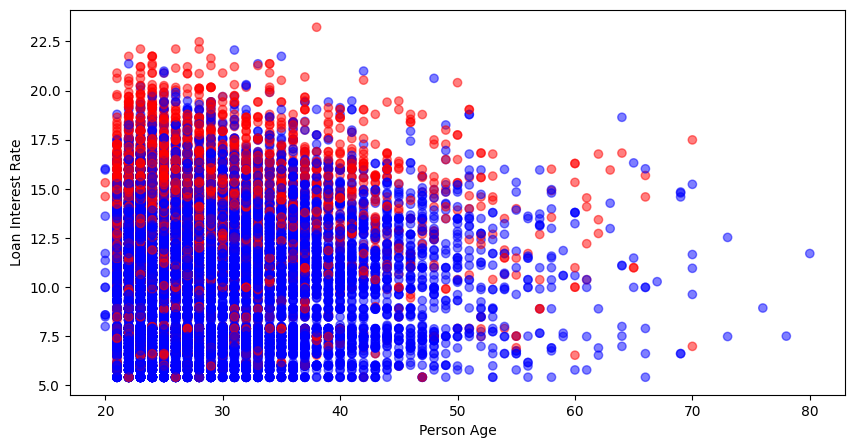

In [291]:
# Use Pandas to drop the record from the data frame and create a new one
cr_loan_new = cr_loan.drop(cr_loan[cr_loan['person_age'] > 80].index)

# Create a scatter plot of age and interest rate
colors = ["blue","red"]
plt.figure(figsize=(10,5))
plt.scatter(cr_loan_new['person_age'], cr_loan_new['loan_int_rate'],
            c = cr_loan_new['loan_status'],
            cmap = mpl.colors.ListedColormap(colors),
            alpha=0.5)
plt.xlabel("Person Age")
plt.ylabel("Loan Interest Rate")
plt.show()

In the last plotwe have loan_status as a label for colors. This shows a different color depending on the class. In this case, it's loan default and non-default, and it looks like there are more defaults with high interest rates.

## Replacing missing data

In [292]:
# Print a null value column array
cr_loan_new .columns[cr_loan_new .isnull().any()]

Index(['person_emp_length', 'loan_int_rate'], dtype='object')

In [293]:
# Print the top five rows with nulls for employment length
cr_loan_new[cr_loan_new['person_emp_length'].isnull()].head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
105,22,12600,MORTGAGE,NaN,PERSONAL,A,2000,$5.42,1,$0.16,N,4
222,24,185000,MORTGAGE,NaN,EDUCATION,B,35000,$12.42,0,$0.19,N,2
379,24,16800,MORTGAGE,NaN,DEBTCONSOLIDATION,A,3900,NaN,1,$0.23,N,3
407,25,52000,RENT,NaN,PERSONAL,B,24000,$10.74,1,$0.46,N,2
408,22,17352,MORTGAGE,NaN,EDUCATION,C,2250,$15.27,0,$0.13,Y,3


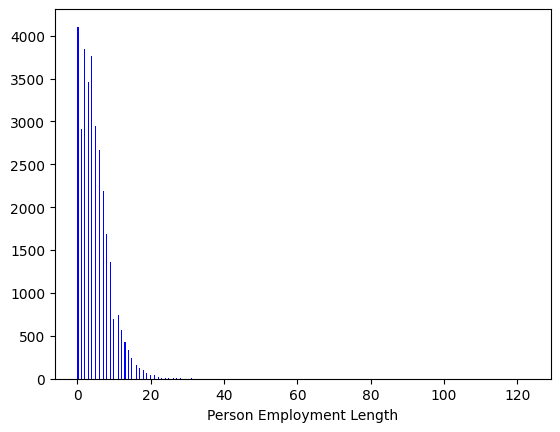

In [294]:
# Impute the null values with the median value for all employment lengths
cr_loan_new ['person_emp_length'].fillna((cr_loan['person_emp_length'].median()), inplace=True)

# Create a histogram of employment length
n, bins, patches = plt.hist(cr_loan_new['person_emp_length'], bins='auto', color='blue')
plt.xlabel("Person Employment Length")
plt.show()

In [295]:
# Print the number of nulls
cr_loan_new['loan_int_rate'].isnull().sum()

3114

In [296]:
# Store the array on indices
indices = cr_loan_new[cr_loan_new['loan_int_rate'].isnull()].index

# Save the new data without missing data
cr_loan_clean = cr_loan_new.drop(indices)

In [297]:
# Print the number of nulls
cr_loan_clean.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

# Logistic Regression for Defaults

In [298]:
# Create the X and y data sets
X = cr_loan_clean[['loan_int_rate', 'person_emp_length', 'person_income']]
y = cr_loan_clean[['loan_status']]

# Use test_train_split to create the training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=123)

# Create and fit the logistic regression model
clf_logistic = LogisticRegression(solver='lbfgs').fit(X_train, np.ravel(y_train))

# Print the models coefficients
print(clf_logistic.coef_)

[[ 2.81358140e-01 -1.89722054e-02 -2.08733334e-05]]


 Three columns were used for training and there are three values in .coef_. This tells us how important each column, or feature, was for predicting. The more positive the value, the more it predicts defaults. 

## One-hot encoding credit data

In [299]:
# Create two data sets for numeric and non-numeric data
cred_num = cr_loan_clean.select_dtypes(exclude=['object'])
cred_str = cr_loan_clean.select_dtypes(include=['object'])

# One-hot encode the non-numeric columns
cred_str_onehot = pd.get_dummies(cred_str)

# Union the one-hot encoded columns to the numeric ones
cr_loan_prep = pd.concat([cred_num, cred_str_onehot], axis=1)

# Print the columns in the new data set
print(cr_loan_prep.columns)

Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_cred_hist_length', 'person_home_ownership_MORTGAGE',
       'person_home_ownership_OTHER', 'person_home_ownership_OWN',
       'person_home_ownership_RENT', 'loan_intent_DEBTCONSOLIDATION',
       'loan_intent_EDUCATION', 'loan_intent_HOMEIMPROVEMENT',
       'loan_intent_MEDICAL', 'loan_intent_PERSONAL', 'loan_intent_VENTURE',
       'loan_grade_A', 'loan_grade_B', 'loan_grade_C', 'loan_grade_D',
       'loan_grade_E', 'loan_grade_F', 'loan_grade_G',
       'cb_person_default_on_file_N', 'cb_person_default_on_file_Y'],
      dtype='object')


## Predicting probability of default

In [300]:
# Create the X and y data sets
X = cr_loan_prep.drop('loan_status', axis =1)
y = cr_loan_prep[['loan_status']]

# Use test_train_split to create the training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=123)
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((17676, 26), (11784, 26), (17676, 1), (11784, 1))

In [301]:
# Train the logistic regression model on the training data
clf_logistic = LogisticRegression(solver='lbfgs').fit(X_train, np.ravel(y_train))

# Create predictions of probability for loan status using test data
preds = clf_logistic.predict_proba(X_test)

# Create dataframes of first five predictions, and first five true labels
preds_df = pd.DataFrame(preds[:,1][0:5], columns = ['prob_default'])
true_df = y_test.head()

# Concatenate and print the two data frames for comparison
print(pd.concat([true_df.reset_index(drop = True), preds_df], axis = 1))

   loan_status  prob_default
0            0         $0.13
1            0         $0.05
2            0         $0.14
3            0         $0.24
4            0         $0.25


It looks like most of the rows with loan_status at 1 have a low probability of default. How good are the rest of the predictions? Next, let's see if we can determine how accurate the entire model is.

## Default classification reporting

In [302]:
# Create a dataframe for the probabilities of default
preds_df2 = pd.DataFrame(preds[:,1], columns = ['prob_default'])

# Reassign loan status based on the threshold
preds_df2['loan_status'] = preds_df2['prob_default'].apply(lambda x: 1 if x > 0.5 else 0)

# Print the row counts for each loan status
print(preds_df2['loan_status'].value_counts())

# Print the classification report
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, preds_df2['loan_status'], target_names=target_names))

0    11217
1      567
Name: loan_status, dtype: int64
              precision    recall  f1-score   support

 Non-Default       0.81      0.98      0.89      9203
     Default       0.75      0.16      0.27      2581

    accuracy                           0.80     11784
   macro avg       0.78      0.57      0.58     11784
weighted avg       0.79      0.80      0.75     11784



It looks like almost all of our test set was predicted to be non-default. The recall for defaults is 0.16 meaning 16% of our true defaults were predicted correctly.

### Selecting report metrics

In [303]:
# Print all the non-average values from the report
print(precision_recall_fscore_support(y_test, preds_df2['loan_status']))

(array([0.80770259, 0.74779541]), array([0.98446159, 0.16427741]), array([0.88736533, 0.26937738]), array([9203, 2581]))


## Visually scoring credit models

In [304]:
# Create predictions and store them in a variable
preds= clf_logistic.predict_proba(X_test)

# Print the accuracy score the model
print(clf_logistic.score(X_test,y_test))

0.8048200950441277


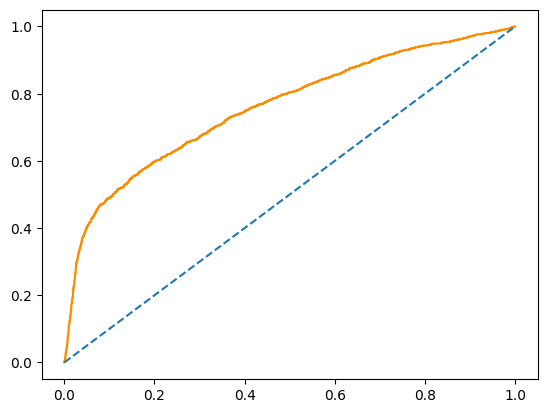

In [305]:
# Plot the ROC curve of the probabilities of default
prob_default = preds[:, 1]
fallout, sensitivity, thresholds = roc_curve(y_test, prob_default)
plt.plot(fallout, sensitivity, color = 'darkorange')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()

In [306]:
# Compute the AUC and store it in a variable
auc = roc_auc_score(y_test, prob_default)
print(auc)

0.7592293721245406


The accuracy for this model is about 80% and the AUC score is 76%. Notice that what the ROC chart shows us is the tradeoff between all values of our false positive rate (fallout) and true positive rate (sensitivity).

## Model discrimination and impact

Now we can assess the financial impact using the default recall which is selected from the classification reporting using the function precision_recall_fscore_support().

For this, we  will estimate the amount of unexpected loss using the default recall to find what proportion of defaults we did not catch with the new threshold. This will be a dollar amount which tells us how much in losses we would have if all the unfound defaults were to default all at once.

In [307]:
len(y_test), len(preds_df2['loan_status'])

(11784, 11784)

In [308]:
# Reassign the values of loan status based on the new threshold
preds_df2['loan_status'] = preds_df2['prob_default'].apply(lambda x: 1 if x > 0.4 else 0)

# Store the number of loan defaults from the prediction data
num_defaults = preds_df2['loan_status'].value_counts()[0]

# Store the default recall from the classification report
default_recall = precision_recall_fscore_support(y_test, preds_df2['loan_status'])[1][1]

# Calculate the estimated impact of the new default recall rate
avg_loan_amnt = cr_loan_prep['loan_amnt'].mean()
print(avg_loan_amnt * num_defaults * (1 - default_recall))

51066724.3857207


### Threshold selection

In [309]:
thresh = np.arange(0.1, 0.65, 0.025)
def_recalls =[]
nondef_recalls = []
accs = []
for n in thresh :
    # Reassign loan status based on the threshold
    preds_df2['loan_status'] = preds_df2['prob_default'].apply(lambda x: 1 if x > n else 0)
    def_recalls.append(precision_recall_fscore_support(y_test, preds_df2['loan_status'])[1][1])
    nondef_recalls.append(precision_recall_fscore_support(y_test, preds_df2['loan_status'])[1][0]) 
    accs.append(accuracy_score(y_test, preds_df2['loan_status']))

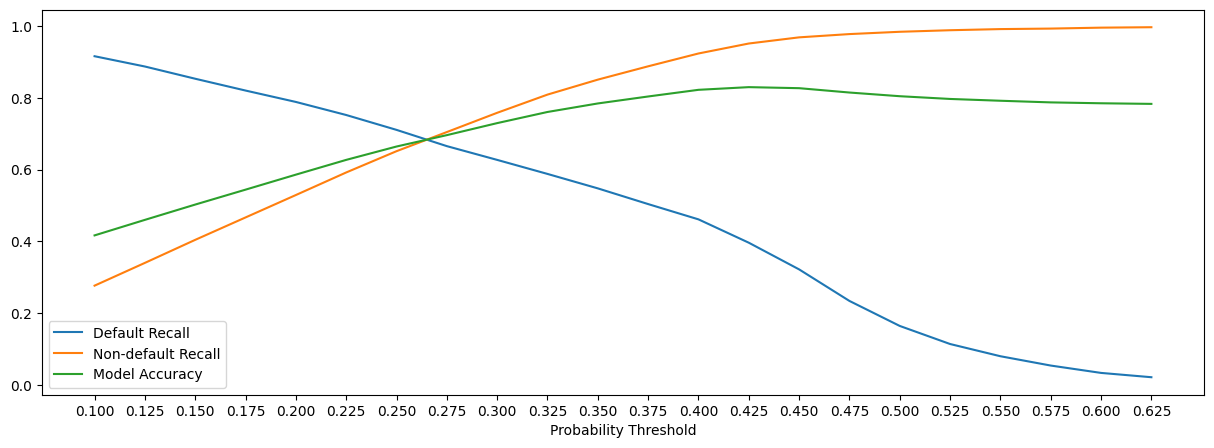

In [310]:
ticks = thresh 
plt.figure(figsize =(15,5))
plt.plot(thresh,def_recalls)
plt.plot(thresh,nondef_recalls)
plt.plot(thresh,accs)
plt.xlabel("Probability Threshold")
plt.xticks(ticks)
plt.legend(["Default Recall","Non-default Recall","Model Accuracy"])
plt.show()

0.262 is the threshold value that would maximize these scores evenly. This is the easiest pattern to see on this graph, because it's the point where all three lines converge. This threshold would make a great starting point, but declaring all loans about 0.262 to be a default is probably not practical

# Gradient boosted trees with XGBoost


In [311]:
# Train a model
import xgboost as xgb
clf_gbt = xgb.XGBClassifier().fit(X_train, np.ravel(y_train))

# Predict with a model
gbt_preds2 = clf_gbt.predict_proba(X_test)

# Create dataframes of first five predictions, and first five true labels
preds_df = pd.DataFrame(gbt_preds2[:,1][0:5], columns = ['prob_default'])
true_df = y_test.head()

# Concatenate and print the two data frames for comparison
print(pd.concat([true_df.reset_index(drop = True), preds_df], axis = 1))

   loan_status  prob_default
0            0         $0.00
1            0         $0.01
2            0         $0.02
3            0         $0.04
4            0         $0.00


### Gradient boosted portfolio performance

In [312]:
# Create a data frame called portfolio that combine the probabilities of default for both models, the loss given default # ##(assume 20% for now), and the loan_amnt which will be assumed to be the exposure at default.
portfolio = pd.DataFrame(X_test['loan_amnt'])
portfolio['gbt_prob_default'] = gbt_preds2[:,1]
portfolio['lr_prob_default'] = preds[:,1]
portfolio['lgd'] = 0.2
portfolio.head()

,loan_amnt,gbt_prob_default,lr_prob_default,lgd
19558,3000,$0.00,$0.13,$0.20
17863,35000,$0.01,$0.05,$0.20
12905,15000,$0.02,$0.14,$0.20
3458,10800,$0.04,$0.24,$0.20
26093,2000,$0.00,$0.25,$0.20


In [313]:
# Create expected loss columns for each model using the formula
portfolio['gbt_expected_loss'] = portfolio['gbt_prob_default'] * portfolio['lgd'] * portfolio['loan_amnt']
portfolio['lr_expected_loss'] = portfolio['lr_prob_default'] * portfolio['lgd'] * portfolio['loan_amnt']

# Print the sum of the expected loss for lr
print('LR expected loss: ', np.sum(portfolio['lr_expected_loss']))

# Print the sum of the expected loss for gbt
print('GBT expected loss: ', np.sum(portfolio['gbt_expected_loss']))

LR expected loss:  5585357.830665553
GBT expected loss:  5462944.388891017


It looks like the total expected loss for the XGBClassifier() model is quite a bit lower. When we talk about accuracy and precision, the goal is to generate models which have a low expected loss. Looking at a classification_report() helps as well.

### Assessing gradient boosted trees

In [314]:
# Predict the labels for loan status
gbt_preds = clf_gbt.predict(X_test)

# Check the values created by the predict method
print(gbt_preds)

# Print the classification report of the model
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, gbt_preds, target_names=target_names))

[0 0 0 ... 0 0 0]
              precision    recall  f1-score   support

 Non-Default       0.93      0.99      0.96      9203
     Default       0.94      0.73      0.82      2581

    accuracy                           0.93     11784
   macro avg       0.93      0.86      0.89     11784
weighted avg       0.93      0.93      0.93     11784



## Column selection

In [315]:
# Create and train the model on the training data
clf_gbt = xgb.XGBClassifier().fit(X_train,np.ravel(y_train))

# Print the column importances from the model
print(clf_gbt.get_booster().get_score(importance_type = 'weight'))

{'person_age': 215.0, 'person_income': 749.0, 'person_emp_length': 240.0, 'loan_amnt': 331.0, 'loan_int_rate': 419.0, 'loan_percent_income': 238.0, 'cb_person_cred_hist_length': 152.0, 'person_home_ownership_MORTGAGE': 50.0, 'person_home_ownership_OTHER': 1.0, 'person_home_ownership_OWN': 41.0, 'person_home_ownership_RENT': 66.0, 'loan_intent_DEBTCONSOLIDATION': 47.0, 'loan_intent_EDUCATION': 29.0, 'loan_intent_HOMEIMPROVEMENT': 49.0, 'loan_intent_MEDICAL': 76.0, 'loan_intent_PERSONAL': 28.0, 'loan_intent_VENTURE': 29.0, 'loan_grade_A': 1.0, 'loan_grade_B': 17.0, 'loan_grade_C': 26.0, 'loan_grade_D': 47.0, 'loan_grade_E': 17.0, 'loan_grade_F': 9.0, 'loan_grade_G': 11.0, 'cb_person_default_on_file_N': 27.0}


The importance for loan_grade_F is only 9 in this case. This could be because there are so few of the F-grade loans. While the F-grade loans don't add much to predictions here, they might affect the importance of other training columns. When the model is trained on different sets of columns it changes the performance, but does the importance for the same column change depending on which group it's in?

In [316]:
X2 = cr_loan_prep[['loan_int_rate','person_emp_length']]
X3 = cr_loan_prep[['person_income','loan_int_rate','loan_percent_income']]
# Use test_train_split to create the training and test sets
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size=.4, random_state=123)
X3_train, X3_test, y_train, y_test = train_test_split(X3, y, test_size=.4, random_state=123)

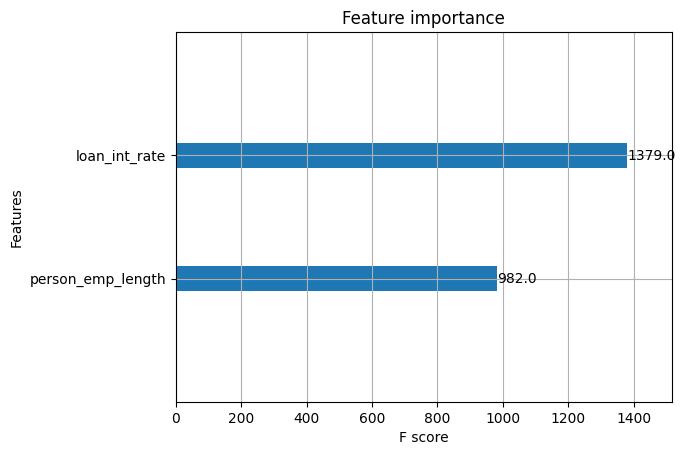

In [317]:
# Train a model on the X data with 2 columns
clf_gbt2 = xgb.XGBClassifier().fit(X2_train,np.ravel(y_train))

# Plot the column importance for this model
xgb.plot_importance(clf_gbt2, importance_type = 'weight')
plt.show()

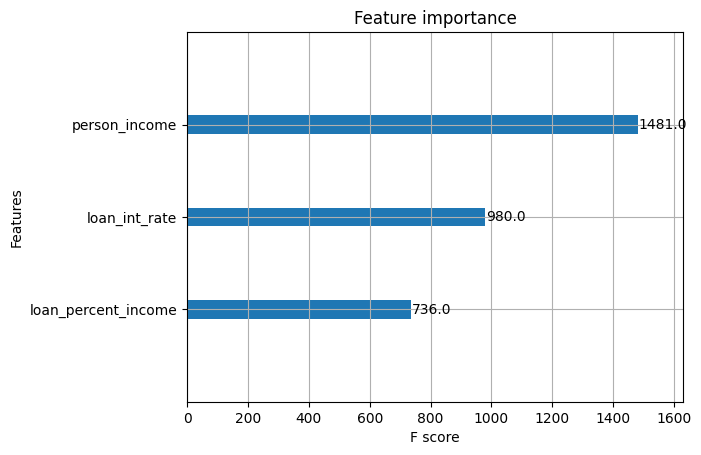

In [318]:
# Train a model on the X data with 3 columns
clf_gbt3 = xgb.XGBClassifier().fit(X3_train,np.ravel(y_train))

# Plot the column importance for this model
xgb.plot_importance(clf_gbt3, importance_type = 'weight')
plt.show()

Take a closer look at the plots. Did you notice that the importance of loan_int_rate went from 1379 to 983? Initially, this was the most important column, but person_income ended up taking the top spot here.

### Column selection and model performance

In [319]:
# Predict the loan_status using each model
gbt2_preds = clf_gbt2.predict(X2_test)
gbt3_preds = clf_gbt3.predict(X3_test)

# Print the classification report of the first model
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, gbt2_preds, target_names=target_names))

# Print the classification report of the second model
print(classification_report(y_test, gbt3_preds, target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.83      0.97      0.89      9203
     Default       0.70      0.28      0.40      2581

    accuracy                           0.82     11784
   macro avg       0.76      0.62      0.65     11784
weighted avg       0.80      0.82      0.78     11784

              precision    recall  f1-score   support

 Non-Default       0.90      0.94      0.92      9203
     Default       0.76      0.63      0.69      2581

    accuracy                           0.88     11784
   macro avg       0.83      0.79      0.81     11784
weighted avg       0.87      0.88      0.87     11784



The highest F-1 score for predicting defaults is 0.69. It looked like the selection of columns affected model accuracy the most, but now we see that the selection of columns also affects recall by quite a bit.

## Cross validating credit models

In [320]:
# Create parameter dictionary
params = {'objective': 'binary:logistic', 'seed': 123, 'eval_metric': 'auc'}

# Set the values for number of folds and stopping iterations
n_folds = 5
early_stopping = 10

# Create the DTrain matrix for XGBoost
DTrain = xgb.DMatrix(X_train, label = y_train)

# Create the data frame of cross validations
cv_df = xgb.cv(params, DTrain, num_boost_round = 5, nfold=5,
            early_stopping_rounds=10)

# Print the cross validations data frame
print(cv_df)

   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0           $0.90          $0.00          $0.89         $0.01
1           $0.91          $0.00          $0.90         $0.00
2           $0.92          $0.00          $0.91         $0.01
3           $0.92          $0.00          $0.91         $0.01
4           $0.92          $0.00          $0.91         $0.01


The AUC for both train-auc-mean and test-auc-mean improves at each iteration of cross-validation

### Limits to cross-validation testing

   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0           $0.90          $0.00          $0.89         $0.01
1           $0.91          $0.00          $0.90         $0.01
2           $0.92          $0.00          $0.91         $0.01
3           $0.92          $0.00          $0.91         $0.01
4           $0.92          $0.00          $0.92         $0.01
0.94


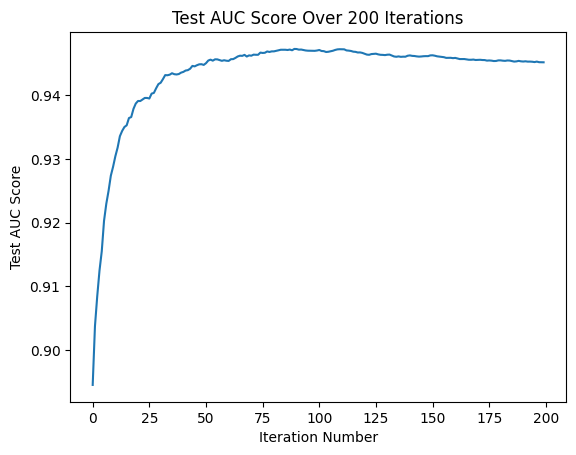

In [321]:
# Performed 200 iterations of cross-validation. The parameter shuffle tells the function to shuffle the records each time
cv_results_big = xgb.cv(params, DTrain, num_boost_round = 200, nfold=10, shuffle = True)

# Print the first five rows of the CV results data frame
print(cv_results_big.head())

# Calculate the mean of the test AUC scores
print(np.mean(cv_results_big['test-auc-mean']).round(2))

# Plot the test AUC scores for each iteration
plt.plot(cv_results_big['test-auc-mean'])
plt.title('Test AUC Score Over 200 Iterations')
plt.xlabel('Iteration Number')
plt.ylabel('Test AUC Score')
plt.show()

Notice that the test AUC score never quite reaches 1.0 and begins to decrease slightly after 100 iterations. This is because this much cross-validation can actually cause the model to become overfit. So, there is a limit to how much cross-validation you should t

### Cross-validation scoring

In [322]:
# Create a gradient boosted tree model using two hyperparameters
gbt = xgb.XGBClassifier(learning_rate = 0.1, max_depth = 7)

# Calculate the cross validation scores for 4 folds
cv_scores = cross_val_score(gbt, X_train, np.ravel(y_train), cv = 4)

# Print the cross validation scores
print(cv_scores)

# Print the average accuracy and standard deviation of the scores
print("Average accuracy: %0.2f (+/- %0.2f)" % (cv_scores.mean(),
                                              cv_scores.std() * 2))

[0.93346911 0.94229464 0.92849061 0.93527947]
Average accuracy: 0.93 (+/- 0.01)


With only a couple of hyperparameters and cross-validation, we can get the average accuracy up to 93%. This is a great way to validate how robust the model is.

## Class imbalance

### Undersampling training data
The test set represents the type of data that will be seen by the model in the real world, so changing it would test the model on unrealistic data.

In [323]:
X_y_train = pd.concat([X_train.reset_index(drop = True),
                       y_train.reset_index(drop = True)], axis = 1)
count_nondefault, count_default = X_y_train['loan_status'].value_counts()

In [324]:
# Create data sets for defaults and non-defaults
nondefaults = X_y_train[X_y_train['loan_status'] == 0]
defaults= X_y_train[X_y_train['loan_status'] == 1]

# Undersample the non-defaults
nondefaults_under = nondefaults.sample(count_default)

# Concatenate the undersampled nondefaults with defaults
X_y_train_under = pd.concat([nondefaults_under.reset_index(drop = True),
                             defaults.reset_index(drop = True)], axis = 0)

# Print the value counts for loan status
print(X_y_train_under['loan_status'].value_counts())

0    3883
1    3883
Name: loan_status, dtype: int64


### Undersampled tree performance

In [325]:
# Split the data 
X_train_under = X_y_train_under.drop('loan_status', axis =1) 
y_train_under = X_y_train_under['loan_status'] 

# Train a model on the X data with 3 columns
clf_gbt_under = xgb.XGBClassifier().fit(X_train_under ,np.ravel(y_train_under ))

# Predict the loan_status using each model
gbt_preds_under = clf_gbt_under.predict(X_test)

In [326]:
# Check the classification reports
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, gbt_preds, target_names=target_names))
print(classification_report(y_test, gbt_preds_under, target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.93      0.99      0.96      9203
     Default       0.94      0.73      0.82      2581

    accuracy                           0.93     11784
   macro avg       0.93      0.86      0.89     11784
weighted avg       0.93      0.93      0.93     11784

              precision    recall  f1-score   support

 Non-Default       0.95      0.92      0.93      9203
     Default       0.73      0.82      0.77      2581

    accuracy                           0.90     11784
   macro avg       0.84      0.87      0.85     11784
weighted avg       0.90      0.90      0.90     11784



In [327]:
# Print the confusion matrix for both old and new models
print(confusion_matrix(y_test,gbt_preds))
print(confusion_matrix(y_test,gbt_preds_under))

[[9081  122]
 [ 690 1891]]
[[8427  776]
 [ 459 2122]]


In [328]:
# Print and compare the AUC scores of the old and new models
print(roc_auc_score(y_test, gbt_preds))
print(roc_auc_score(y_test, gbt_preds_under))

0.8597026061149559
0.8689208112022161


Undersampling the training data results in more false positives, but the recall for defaults and the AUC score are both higher than the original model. This means overall it predicts defaults much more accurately.

# Model evaluation and implementation

One of the easiest first steps for comparing different models' ability to predict the probability of default is to look at their metrics from the classification_report().

In [329]:
# label predictions for the logistic regression
preds_df_lr = preds_df2

# Create a dataframe for the probabilities of default for XGB Classifier
preds_df2 = pd.DataFrame(gbt_preds2[:,1], columns = ['prob_default'])

# Reassign loan status based on the threshold
preds_df2['loan_status']  = preds_df2['prob_default'].apply(lambda x: 1 if x > 0.4 else 0)

# label predictions for for the gradient boosted tree
preds_df_gbt = preds_df2

In [330]:
preds_df_lr.columns

Index(['prob_default', 'loan_status'], dtype='object')

In [331]:
# Print the logistic regression classification report
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, preds_df_lr['loan_status'], target_names=target_names))

# Print the gradient boosted tree classification report
print(classification_report(y_test, preds_df_gbt['loan_status'], target_names=target_names))

# Print the default F-1 scores for the logistic regression
print(precision_recall_fscore_support(y_test,preds_df_lr['loan_status'], average = 'macro')[2])

# Print the default F-1 scores for the gradient boosted tree
print(precision_recall_fscore_support(y_test,preds_df_gbt['loan_status'], average = 'macro')[2])

              precision    recall  f1-score   support

 Non-Default       0.78      1.00      0.88      9203
     Default       0.68      0.02      0.04      2581

    accuracy                           0.78     11784
   macro avg       0.73      0.51      0.46     11784
weighted avg       0.76      0.78      0.69     11784

              precision    recall  f1-score   support

 Non-Default       0.93      0.98      0.96      9203
     Default       0.91      0.76      0.82      2581

    accuracy                           0.93     11784
   macro avg       0.92      0.87      0.89     11784
weighted avg       0.93      0.93      0.93     11784

0.4596260474868617
0.8901068344502041


## Comparing with ROCs
 The lift is how far the curve is from the random prediction. The AUC is the area between the curve and the random prediction. The model with more lift, and a higher AUC, is the one that's better at making predictions accurately.

In [332]:
# label the predictions for the probability of default 
clf_logistic_preds = clf_logistic.predict(X_test)
clf_gbt_preds = clf_gbt.predict(X_test)

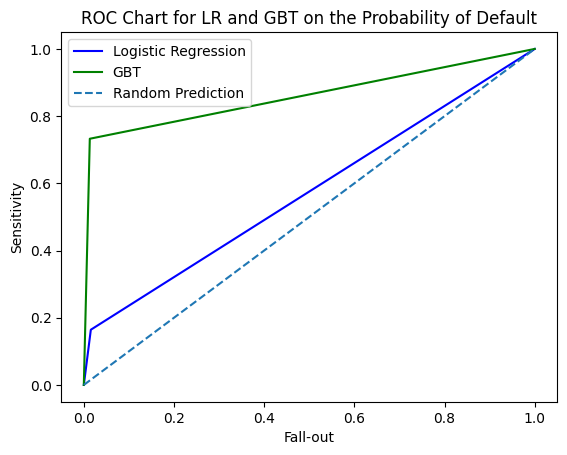

In [333]:
# ROC chart components
fallout_lr, sensitivity_lr, thresholds_lr = roc_curve(y_test, clf_logistic_preds)
fallout_gbt, sensitivity_gbt, thresholds_gbt = roc_curve(y_test, clf_gbt_preds)

# ROC Chart with both
plt.plot(fallout_lr, sensitivity_lr, color = 'blue', label='%s' % 'Logistic Regression')
plt.plot(fallout_gbt, sensitivity_gbt, color = 'green', label='%s' % 'GBT')
plt.plot([0, 1], [0, 1], linestyle='--', label='%s' % 'Random Prediction')
plt.title("ROC Chart for LR and GBT on the Probability of Default")
plt.xlabel('Fall-out')
plt.ylabel('Sensitivity')
plt.legend()
plt.show()

In [334]:
# Print the logistic regression AUC with formatting
print("Logistic Regression AUC Score: %0.2f" % roc_auc_score(y_test, clf_logistic_preds))

# Print the gradient boosted tree AUC with formatting
print("Gradient Boosted Tree AUC Score: %0.2f" % roc_auc_score(y_test, clf_gbt_preds))

Logistic Regression AUC Score: 0.57
Gradient Boosted Tree AUC Score: 0.86


Look at the ROC curve for the gradient boosted tree. Not only is the lift much higher, the calculated AUC score is also quite a bit higher. It's beginning to look like the gradient boosted tree is best.

## Calibration curves
The calibration_curve() function can be useful to evaluate the calibration of a binary classifier, which refers to the agreement between the predicted probabilities and the observed frequencies of the positive class. If the calibration curve is close to the ideal diagonal line, it means that the classifier is well-calibrated, i.e., the predicted probabilities are reliable estimates of the true probabilities. A sample of loans and their predicted probabilities of default should be close to the percentage of defaults in tha sample.

In [335]:
from sklearn.calibration import calibration_curve
frac_of_pos_lr, mean_pred_val_lr = calibration_curve(y_test, preds_df_lr['prob_default'], n_bins = 20)
frac_of_pos_gbt, mean_pred_val_gbt = calibration_curve(y_test, preds_df_gbt['prob_default'], n_bins = 20)

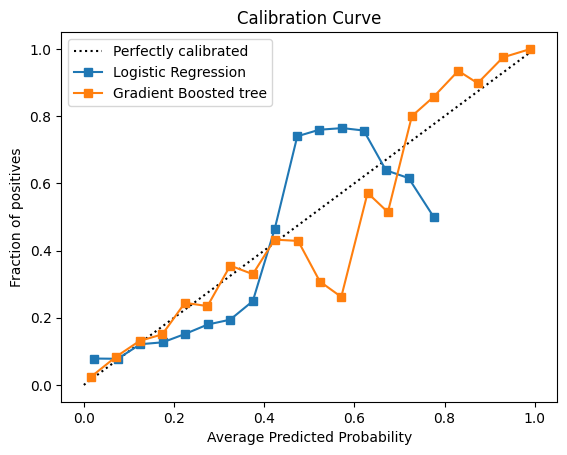

In [336]:
# Create the calibration curve plot with the guideline
plt.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')    
# Add the calibration curve for the logistic regression to the plot 
plt.plot(mean_pred_val_lr, frac_of_pos_lr, 's-', label='%s' % 'Logistic Regression')
# Add the calibration curve for the gradient boosted tree
plt.plot(mean_pred_val_gbt, frac_of_pos_gbt, 's-', label='%s' % 'Gradient Boosted tree')
plt.ylabel('Fraction of positives')
plt.xlabel('Average Predicted Probability')
plt.legend()
plt.title('Calibration Curve')
plt.show()

Notice that for the logistic regression, the calibration for probabilities starts off great but then gets more erratic as it the average probability approaches 0.4. Something similar happens to the gradient boosted tree around 0.5, but the model eventually stabilizes. We will be focusing on only the gbt model from now on.

## Acceptance rates
Setting an acceptance rate and calculating the threshold for that rate can be used to set the percentage of new loans you want to accept.


In [337]:
# Check the statistics of the probabilities of default
print(preds_df2['prob_default'].describe())

# Calculate the threshold for a 85% acceptance rate
threshold_85 = np.quantile(preds_df2['prob_default'], 0.85)

# Apply acceptance rate threshold
preds_df2['pred_loan_status'] = preds_df2['prob_default'].apply(lambda x: 1 if x > threshold_85  else 0)

# Print the counts of loan status after the threshold
print(preds_df2['pred_loan_status'].value_counts())

count   $11,784.00
mean         $0.21
std          $0.34
min          $0.00
25%          $0.01
50%          $0.04
75%          $0.19
max          $1.00
Name: prob_default, dtype: float64
0    10016
1     1768
Name: pred_loan_status, dtype: int64


## Visualizing quantiles of acceptance

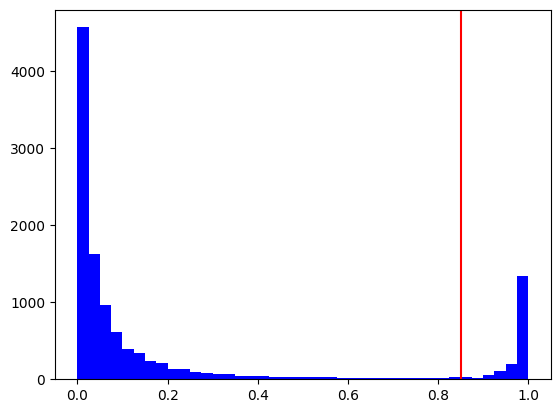

In [338]:
# Plot the predicted probabilities of default
plt.hist(preds_df2['prob_default'], color = 'blue', bins = 40)

# Calculate the threshold with quantile
threshold = np.quantile(preds_df2['prob_default'], 0.85)
# Add a reference line to the plot for the threshold
plt.axvline(x = 0.85, color = 'red')
plt.show()

Here, you can see where the threshold is on the range of predicted probabilities. Not only can you see how many loans will be accepted (left side), but also how many loans will be rejected (right side)

## Bad rates

In [339]:
preds_df2

,prob_default,loan_status,pred_loan_status
0,$0.00,0,0
1,$0.01,0,0
2,$0.02,0,0
3,$0.04,0,0
4,$0.00,0,0
...,...,...,...
11779,$0.00,0,0
11780,$0.00,0,0
11781,$0.03,0,0
11782,$0.35,0,0


In [340]:
# Print the top 5 rows of the new data frame
print(preds_df2.head())

# Create a subset of only accepted loans
accepted_loans = preds_df2[preds_df2['pred_loan_status'] ==0]

# Calculate the bad rate
print(np.sum(accepted_loans['loan_status']) / accepted_loans['loan_status'].count())

   prob_default  loan_status  pred_loan_status
0         $0.00            0                 0
1         $0.01            0                 0
2         $0.02            0                 0
3         $0.04            0                 0
4         $0.00            0                 0
0.03883785942492013


This means that of all the loans we've decided to accept from the test set, only 4% were actual defaults! 

### Acceptance rate impact 
Now, look at the loan_amnt of each loan to understand the impact on the portfolio for the acceptance rates

In [341]:
# create a new column 'loan_amnt' for the preds_df2
preds_df2['loan_amnt'] = X_test['loan_amnt']
preds_df2.head()

,prob_default,loan_status,pred_loan_status,loan_amnt
0,$0.00,0,0,NaN
1,$0.01,0,0,NaN
2,$0.02,0,0,NaN
3,$0.04,0,0,NaN
4,$0.00,0,0,NaN


In [342]:
# Print the statistics of the loan amount column
print(preds_df2['loan_amnt'].describe())

count    $4,224.00
mean     $8,333.99
std      $5,565.12
min        $500.00
25%      $4,800.00
50%      $7,000.00
75%     $10,000.00
max     $35,000.00
Name: loan_amnt, dtype: float64


In [343]:
# Store the average loan amount
avg_loan = np.mean(preds_df2['loan_amnt'])

# Set the formatting for currency, and print the cross tab
# pd.options.display.float_format = '${:,.2f}'.format
print(pd.crosstab(preds_df2['loan_status'],
                 preds_df2['pred_loan_status']).apply(lambda x: x * avg_loan, axis = 0))

pred_loan_status              0              1
loan_status                                   
0                $80,231,324.56          $0.00
1                 $3,241,922.22 $14,734,494.84


With this, we can see that our bad rate of about 4% represents an estimated loan value of about 3.2 million dollars. This may seem like a lot at first, but compare it to the total value of non-default loans!

## Selecting acceptance rates

In [344]:
# Set all the acceptance rates to test
accept_rates = [1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55,
0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05]
# Create lists to store thresholds and bad rates
thresholds = []
bad_rates = []

In [345]:
preds_df_gbt['true_loan_status'] = y_test
preds_df_gbt.head()

,prob_default,loan_status,pred_loan_status,loan_amnt,true_loan_status
0,$0.00,0,0,NaN,NaN
1,$0.01,0,0,NaN,NaN
2,$0.02,0,0,NaN,NaN
3,$0.04,0,0,NaN,NaN
4,$0.00,0,0,NaN,NaN


In [346]:
# Strategy table interpretation
strat_df = pd.DataFrame(zip(accept_rates, thresholds, bad_rates), columns = ['Acceptance Rate','Threshold','Bad Rate'])

In [347]:
# Calculating the table values
for rate in accept_rates:
    # Calculate threshold
    threshold = np.quantile(preds_df_gbt['prob_default'], rate).round(3)
    # Store threshold value in a list
    thresholds.append(threshold)
    # Apply the threshold to reassign loan_status
    preds_df_gbt['pred_loan_status'] = np.where(preds_df_gbt['prob_default'] > threshold, 1, 0)
    # Create accepted loans set of predicted non-defaults
    accepted_loans = preds_df_gbt[preds_df_gbt['pred_loan_status'] == 0]
    # Calculate and store bad rate
    bad_rates.append(np.sum((accepted_loans['true_loan_status'])
                    / accepted_loans['true_loan_status'].count()).round(3))

In [348]:
# Strategy table interpretation
strat_df = pd.DataFrame(zip(accept_rates, thresholds, bad_rates), columns = ['Acceptance Rate','Threshold','Bad Rate'])
strat_df

,Acceptance Rate,Threshold,Bad Rate
0,$1.00,$1.00,$0.23
1,$0.95,$1.00,$0.23
2,$0.90,$0.98,$0.23
3,$0.85,$0.83,$0.23
4,$0.80,$0.31,$0.23
5,$0.75,$0.18,$0.23
6,$0.70,$0.13,$0.23
7,$0.65,$0.10,$0.23
8,$0.60,$0.07,$0.23
9,$0.55,$0.06,$0.23


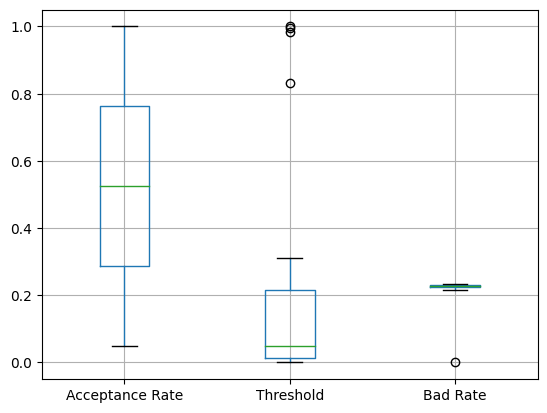

In [349]:
# Visualize the distributions in the strategy table with a boxplot
strat_df.boxplot()
plt.show()

### Total expected loss
We will assume that the exposure is the full value of the loan, and the loss given default is 100%. This means that a default on each the loan is a loss of the entire amount.

In [350]:
preds_df2['loss_given_default'] = 1
preds_df2.head()

,prob_default,loan_status,pred_loan_status,loan_amnt,true_loan_status,loss_given_default
0,$0.00,0,1,NaN,NaN,1
1,$0.01,0,1,NaN,NaN,1
2,$0.02,0,1,NaN,NaN,1
3,$0.04,0,1,NaN,NaN,1
4,$0.00,0,1,NaN,NaN,1


In [351]:
# Calculate the bank's expected loss and assign it to a new column
preds_df2['expected_loss'] = preds_df2['prob_default'] * preds_df2['loan_amnt'] * preds_df2['loss_given_default']

# Calculate the total expected loss to two decimal places
tot_exp_loss = round(np.sum(preds_df2['expected_loss']),2)

# Print the total expected loss
tot_exp_loss

7741424.57